In [26]:

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
sys.path.append(os.path.abspath("../lib"))
from all import all_in_one
from show import show_hyperparam_opti
from train import iterate_params, choose_params, nb_possibility
from prepare_data import make_cut, to_categorical


In [27]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [28]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [29]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('int'),
        'heating_emission': F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [30]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop(
    'heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop(
    'heating_emission', 'heating_production')

training_prod = training_tremi.filter(
    F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(
    F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(
    F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(
    F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
{training_em.count() =}
{predicting_em.count() =}
""")


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370

training_em.count() =12558
predicting_em.count() =26940



# ML

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
col_X_hot = [[]]
col_y = ['surface']
col_X_not_hot = [[col[0]
                  for col in training_surf.dtypes if col[0] not in col_X_hot + col_y]]

hyperparams_models = [
    {
        'n_estimators': [100],
        # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
        'max_depth': [10],
        'class_weight': ['balanced'],
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
        # 'max_features' : ["sqrt", "log2", "auto"]
    }
]
models = {
    'RandomForestClassifier': RandomForestClassifier
}
cut_params = {
    'first_value': [30, 40, 50, 60, 70],
    'steps': [25, 35, 45, 55, 65],
    'nb_steps': [1, 2, 3]
}

current = [0 for _ in range(len(cut_params))]
max_hyper = [len(cut_param) - 1 for cut_param in cut_params.values()]
current_params = choose_params(current, cut_params)
all_poss = nb_possibility(max_hyper)
print(all_poss)

cuts = make_cut(**current_params)
categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
# register score
best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                         True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
max_score = deepcopy(best_models['RandomForestClassifier'][1])
best_split = deepcopy(current_params)
scores = {}
coefs = {}
score_corrected = coef * best_models['RandomForestClassifier'][1]
print(score_corrected)
coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
scores[tuple([param for param in current_params.values()])
       ] = deepcopy(score_corrected)

i = 0
nb_print = (all_poss//4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, cut_params)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    cuts = make_cut(**current_params)
    categorical_surf, coef = to_categorical(training_surf, 'surface', cuts)
    best_models = all_in_one(categorical_surf, dictionary, col_X_hot, col_X_not_hot, col_y, False,
                             True, hyperparams_models, models, degree_poly=1, random_state=42, test_size=0.4, show=False)
    score_corrected = coef * best_models['RandomForestClassifier'][1]
    print(score_corrected)
    scores[tuple([param for param in current_params.values()])
           ] = deepcopy(score_corrected)
    coefs[tuple([param for param in current_params.values()])] = deepcopy(coef)
    if score_corrected > max_score:
        max_score = deepcopy(score_corrected)
        best_split = deepcopy(current_params)

75
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 6
min_resources_: 24
max_resources_: 12565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 24
Fitting 4 folds for each of 1 candidates, totalling 4 fits
0.861111111111111 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.0992350886501304
0 [1, 0, 0]
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 6
min_resources_: 24
max_resources_: 12565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 24
Fitting 4 folds for each of 1 candidates, totalling 4 fits
0.75 {'n_estimators': 100, 'max_depth': 10, 'class_weight': 'balanced'}
0.14146438519697568
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 6
min_resources_: 24
max_resources_: 12565
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 24
Fitting 4 folds for each of 1 candidates, totalling 4 fits
0.75 {'n_estimator

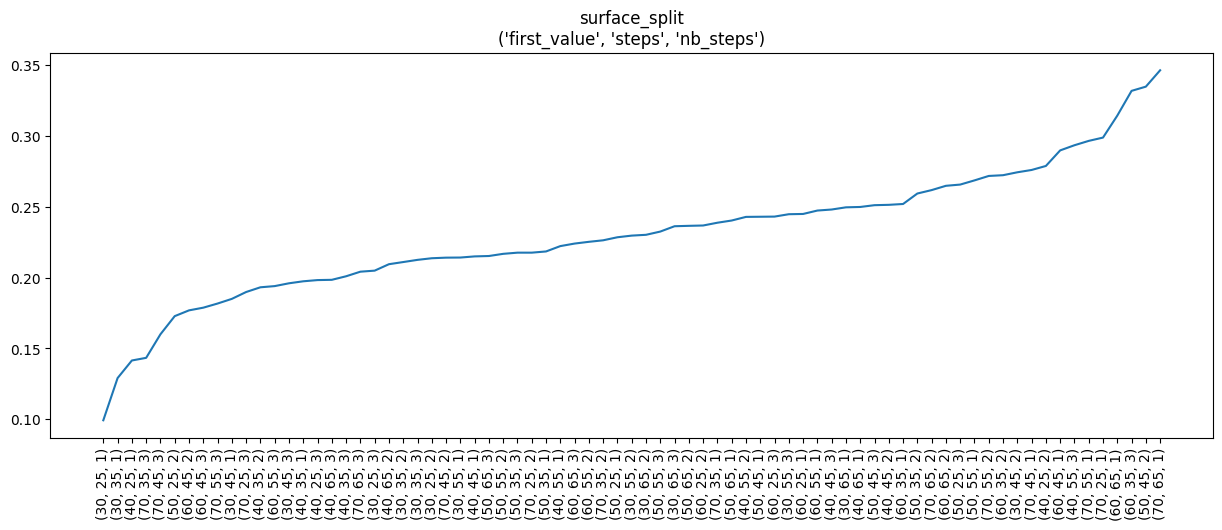

In [33]:
f, ax_hyper = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# show_hyperparam_opti(coefs, cut_params, ax_hyper, 'surface_split')
show_hyperparam_opti(scores, cut_params, ax_hyper, 'surface_split')
plt.show()